In [ ]:
#adapted from 
#https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

In [ ]:
#conda install lxml
#conda install BeautifulSoup4

In [1]:
%matplotlib inline
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d")
bitcoin_market_info = pd.read_html(url)[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
print bitcoin_market_info.dtypes
bitcoin_market_info.head()

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Market Cap             int64
dtype: object


,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-01-18,11198.8,12107.3,10942.50,11474.9,15020400000,188242000000
1,2018-01-17,11431.1,11678.0,9402.29,11188.6,18830600000,192123000000
2,2018-01-16,13836.1,13843.1,10194.90,11490.5,18853800000,232517000000
3,2018-01-15,13767.3,14445.5,13641.70,13819.8,12750800000,231334000000
4,2018-01-14,14370.8,14511.8,13268.00,13772.0,11084100000,241447000000


In [3]:
# get market info for ethereum from the start of 2016 to the current day
url = "https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d")
eth_market_info = pd.read_html(url)[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
print eth_market_info.dtypes
eth_market_info.head()

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Market Cap            object
dtype: object


,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-01-18,1016.44,1100.31,967.76,1036.28,5938320000,98642100000
1,2018-01-17,1061.34,1090.23,780.92,1014.25,8545160000,102974000000
2,2018-01-16,1292.63,1292.63,875.54,1053.69,8405140000,125389000000
3,2018-01-15,1365.21,1390.59,1290.60,1291.92,4781100000,132404000000
4,2018-01-14,1397.48,1400.56,1286.21,1366.77,4841630000,135503000000


In [4]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io
if sys.version_info[0] < 3:
    import urllib2 as urllib
    url = "http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png"
    bt_img = urllib.urlopen(url)
    url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png"
    eth_img = urllib.urlopen(url)
else:
    import urllib
    url = "http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png"
    bt_img = urllib.request.urlopen(url)
    url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png"
    eth_img = urllib.request.urlopen(url)
image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)
image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

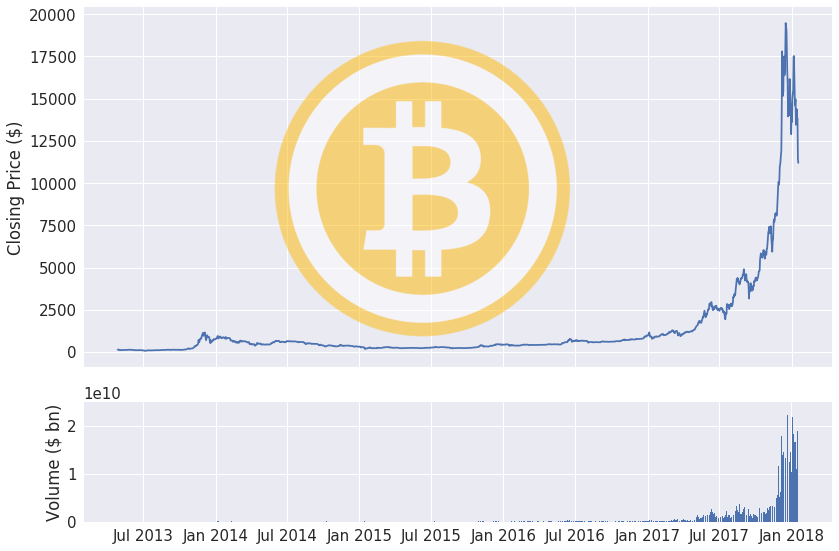

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(12, 8))
#ax1.set_ylabel('Closing Price ($)',fontsize=12)
#ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax1.set_ylabel('Closing Price ($)')
ax2.set_ylabel('Volume ($ bn)')
#ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
#ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()

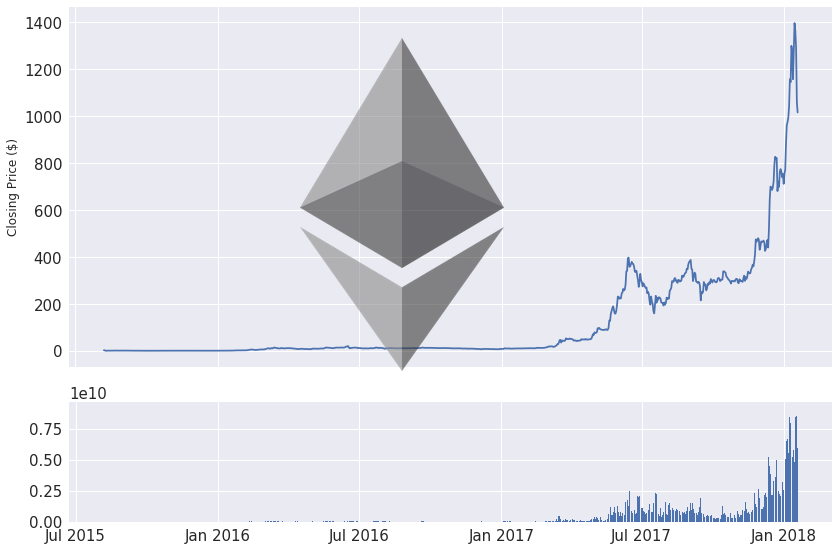

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(12, 8))
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
#ax2.set_ylabel('Volume ($ bn)',fontsize=12)
#ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
#ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 300, 180, zorder=3, alpha=.6)
plt.show()

In [13]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-01-18,11198.8,12107.3,10942.50,11474.9,15020400000,188242000000,1016.44,1100.31,967.76,1036.28,5938320000,98642100000,0.024654,0.019519
1,2018-01-17,11431.1,11678.0,9402.29,11188.6,18830600000,192123000000,1061.34,1090.23,780.92,1014.25,8545160000,102974000000,-0.021214,-0.044368
2,2018-01-16,13836.1,13843.1,10194.90,11490.5,18853800000,232517000000,1292.63,1292.63,875.54,1053.69,8405140000,125389000000,-0.169528,-0.184848
3,2018-01-15,13767.3,14445.5,13641.70,13819.8,12750800000,231334000000,1365.21,1390.59,1290.60,1291.92,4781100000,132404000000,0.003813,-0.053684
4,2018-01-14,14370.8,14511.8,13268.00,13772.0,11084100000,241447000000,1397.48,1400.56,1286.21,1366.77,4841630000,135503000000,-0.041668,-0.021975


In [14]:
market_info.tail()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
744,2016-01-05,433.07,434.18,429.68,431.96,34522600,6515380000,0.953147,0.970597,0.946543,0.950176,219833,72442400,-0.002563,-0.003117
745,2016-01-04,430.06,434.52,429.08,433.09,38477500,6468180000,0.972045,0.976438,0.929835,0.954480,346245,73853900,0.007046,-0.018070
746,2016-01-03,433.58,433.74,424.71,430.01,39633800,6519500000,0.938430,0.991362,0.934313,0.971905,407632,71275900,-0.008234,0.035671
747,2016-01-02,434.62,436.06,431.87,433.44,30096600,6533630000,0.947401,0.969637,0.936560,0.937124,255504,71933100,-0.002715,-0.010848
748,2016-01-01,430.72,436.25,427.51,434.33,36278900,6473530000,0.933712,0.954822,0.931442,0.948024,206062,70870900,0.008381,0.015328


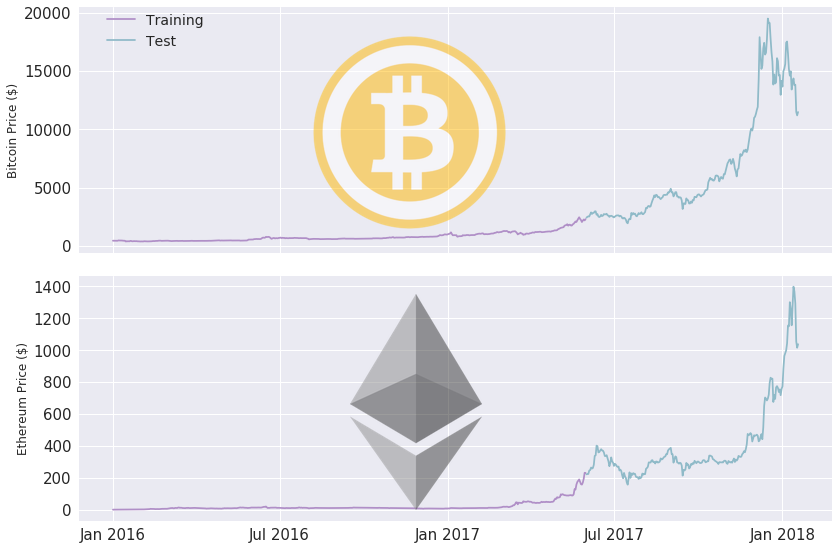

In [16]:
split_date = '2017-06-01'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 260, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 40, zorder=3,alpha=.5)
plt.show()

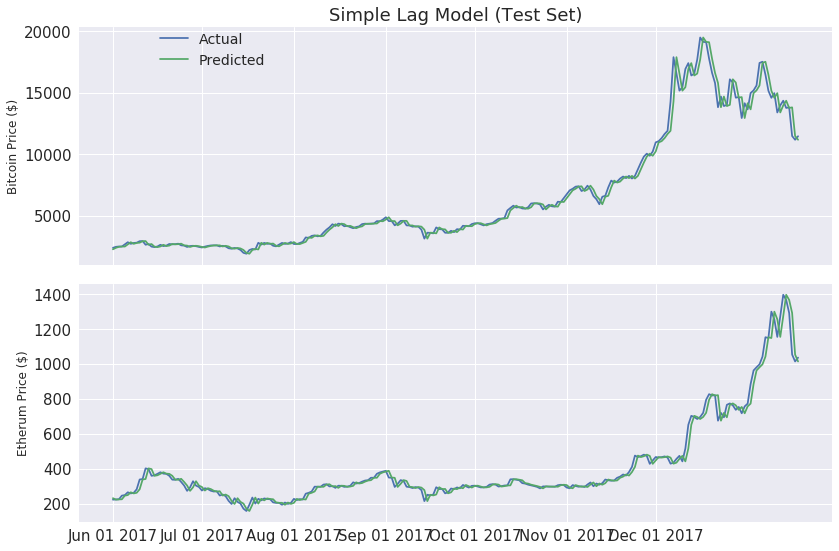

In [17]:
#trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8))
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

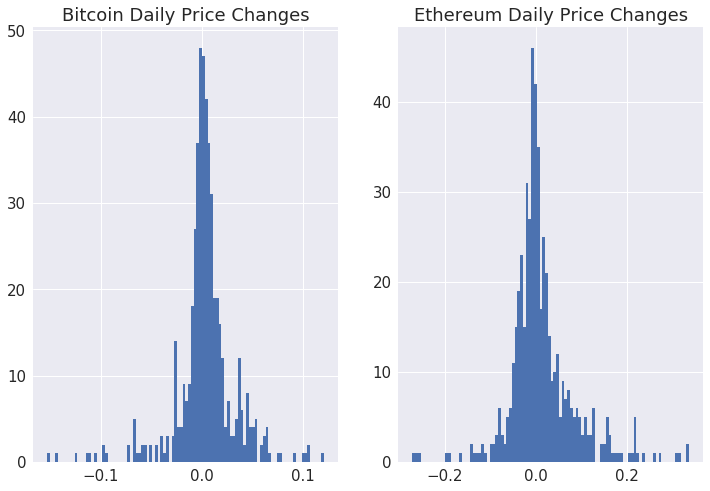

In [19]:
#plot distribution of price changes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

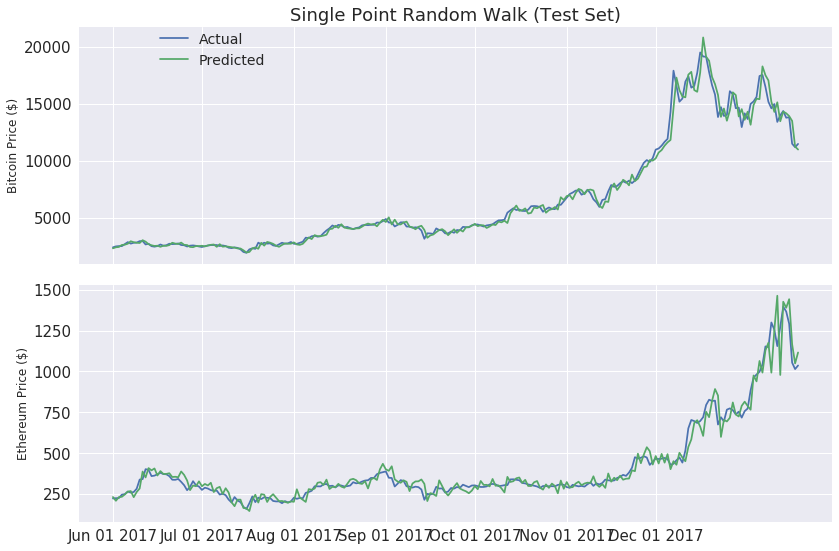

In [21]:
#lagged random walk model
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8))
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

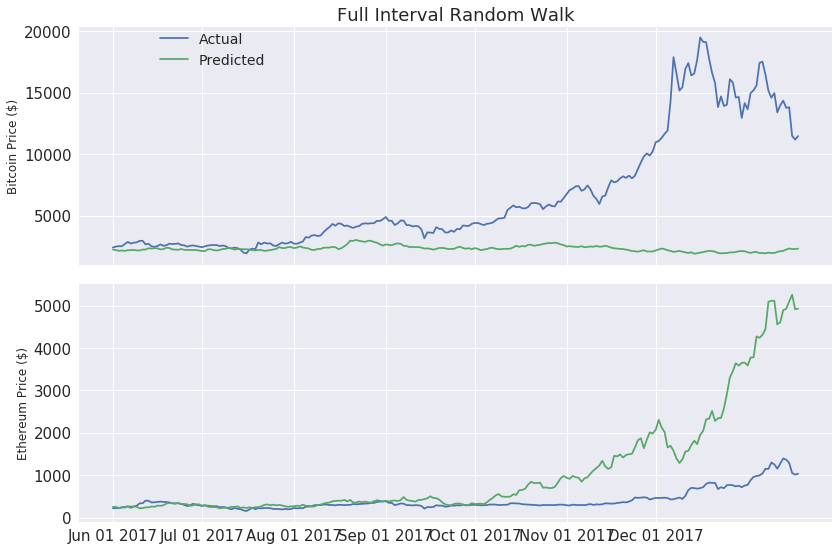

In [22]:
#full interval random walk
bt_random_walk = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         bt_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         eth_random_walk[::-1], label='Predicted')

ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

In [24]:
#LSTM
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
748,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
747,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
746,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
745,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
744,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [26]:
model_data.tail()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
4,2018-01-14,13772.0,11084100000,0.189580,0.086551,1366.77,4841630000,-0.409007,0.081826
3,2018-01-15,13819.8,12750800000,0.556855,0.058385,1291.92,4781100000,0.973597,0.073241
2,2018-01-16,11490.5,18853800000,0.289732,0.263673,1053.69,8405140000,0.145748,0.322668
1,2018-01-17,11188.6,18830600000,-0.569892,0.199081,1014.25,8545160000,-0.508713,0.291433
0,2018-01-18,11474.9,15020400000,0.085852,0.104011,1036.28,5938320000,-0.033874,0.130406


In [54]:
#test-train split
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]
training_set.head()

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
748,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
747,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
746,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
745,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
744,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [55]:
#generate a list of 10-day-long dataframes of training data...also normalize the data?
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = \
    (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1
print len(LSTM_training_inputs)
LSTM_training_inputs[123]

507


,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
625,0.000000,0.000000,-0.811321,0.019068,0.000000,0.000000,0.932584,0.087512
624,-0.007950,-0.150912,0.541053,0.010551,0.010741,-0.178975,0.631579,0.081023
623,-0.005152,-0.150348,-0.596958,0.005887,0.055854,-0.147583,-0.421053,0.080851
622,0.020653,0.226229,-0.751223,0.031946,0.004296,0.002176,0.318681,0.092762
621,0.018299,-0.353767,0.273810,0.007310,0.006445,-0.496527,-0.185185,0.028970
620,0.018321,-0.320912,-0.494186,0.007504,0.018260,-0.299708,-0.641791,0.071505
619,0.022607,-0.065244,-0.327731,0.012985,-0.001074,-0.390358,0.545455,0.046365
618,0.001310,-0.006911,0.701079,0.028186,0.005371,-0.565699,0.090909,0.023707
617,0.005396,-0.147578,-0.005376,0.008251,0.074114,-0.288689,-0.967742,0.065748
616,0.009927,0.008134,-0.936842,0.012598,0.080559,0.124572,0.384615,0.065000


In [56]:
#convert the list of 2D dataframes into 3D numpy arrays
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)
LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)
LSTM_training_inputs.shape, LSTM_test_inputs.shape

((507, 10, 8), (222, 10, 8))

In [57]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [59]:
#helper function creates LSTM model
def build_model(inputs, output_size, neurons, activ_func="linear", dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [60]:
#train LSTM model on etherium data using 20 neurons in LSTM layer
np.random.seed(202)
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = \
    (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=50, batch_size=1, verbose=2, 
    shuffle=True)

Epoch 1/50
8s - loss: 0.1648
Epoch 2/50
8s - loss: 0.1120
Epoch 3/50
8s - loss: 0.1063
Epoch 4/50
8s - loss: 0.0941
Epoch 5/50
8s - loss: 0.0866
Epoch 6/50
8s - loss: 0.0849
Epoch 7/50
8s - loss: 0.0817
Epoch 8/50
8s - loss: 0.0813
Epoch 9/50
7s - loss: 0.0776
Epoch 10/50
8s - loss: 0.0782
Epoch 11/50
8s - loss: 0.0759
Epoch 12/50
7s - loss: 0.0757
Epoch 13/50
7s - loss: 0.0738
Epoch 14/50
7s - loss: 0.0709
Epoch 15/50
7s - loss: 0.0685
Epoch 16/50
7s - loss: 0.0685
Epoch 17/50
7s - loss: 0.0752
Epoch 18/50
7s - loss: 0.0688
Epoch 19/50
7s - loss: 0.0698
Epoch 20/50
7s - loss: 0.0703
Epoch 21/50
7s - loss: 0.0682
Epoch 22/50
7s - loss: 0.0707
Epoch 23/50
7s - loss: 0.0684
Epoch 24/50
7s - loss: 0.0671
Epoch 25/50
7s - loss: 0.0681
Epoch 26/50
8s - loss: 0.0649
Epoch 27/50
7s - loss: 0.0654
Epoch 28/50
7s - loss: 0.0647
Epoch 29/50
7s - loss: 0.0683
Epoch 30/50
7s - loss: 0.0687
Epoch 31/50
7s - loss: 0.0665
Epoch 32/50
7s - loss: 0.0688
Epoch 33/50
7s - loss: 0.0684
Epoch 34/50
7s - lo

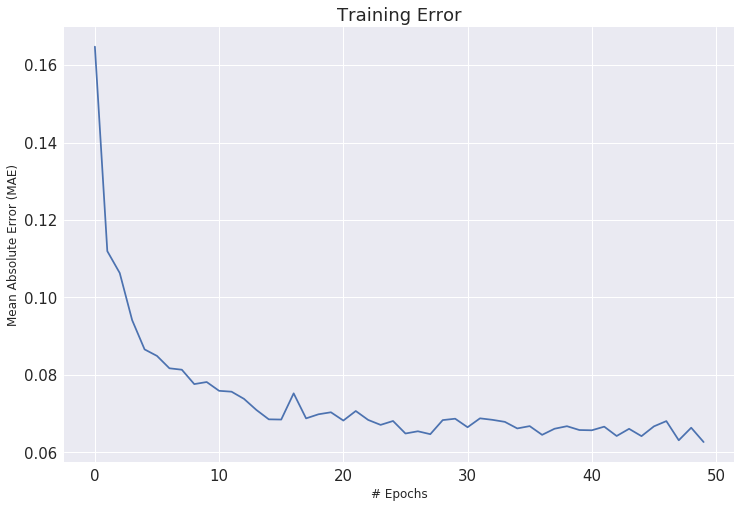

In [67]:
#plot training error vs epoch
fig, ax1 = plt.subplots(1,1, figsize=(12, 8))
ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')
if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

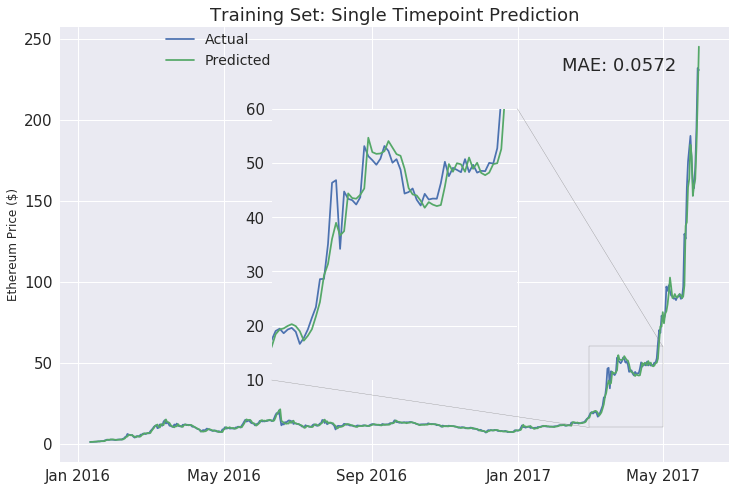

In [69]:
#compare predictions to actuals on training data
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax1 = plt.subplots(1,1, figsize=(12, 8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

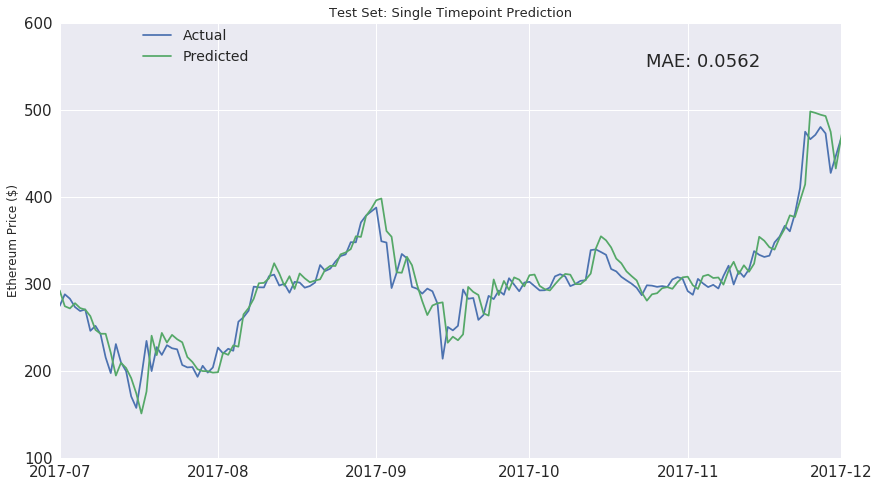

In [79]:
#compare predictions to actuals on test data
fig, ax1 = plt.subplots(1,1, figsize=(14, 8))
#ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_xlim('2017-07-01', '2017-12-01')
ax1.set_ylim(100, 600)
plt.show()

In [81]:
# warning: this cell may take some time to execute
# this code builds 25 LSTM models for eth and bitcoin each (with 25 different initialisations)
# the models are then saved so you hopefully only need to run this cell once
#random seed for reproducibility
for rand_seed in range(775,800):
    print(rand_seed)
    np.random.seed(rand_seed)
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs,
                 (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1,
                 epochs=50, batch_size=1, verbose=0, shuffle=True)
    temp_model.save('eth_model_randseed_%d.h5'%rand_seed)
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs,
                 (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1,
                 epochs=50, batch_size=1, verbose=0, shuffle=True)
    temp_model.save('bt_model_randseed_%d.h5'%rand_seed)

775
776
777


KeyboardInterrupt: 